# Which Indian Bank Should You Choose?

Author: Arissa Noordina Bahari

Date: 7 January 2024


## Introduction

In this notebook, we perform aspect-based sentiment analysis (ABSA) on a dataset of reviews for 10 different Indian banks ([link](https://www.kaggle.com/datasets/dhavalrupapara/banks-customer-reviews-dataset)). For each bank, we want to find out which bank performs the best on each aspect, by analysing the sentiment of the review.

Our aim is to find out which bank performs the best on 3 different aspects:
- Account
- App
- Service

This project was inspired by [Bouaskaoun's](https://github.com/Bouaskaoun/Aspect-Based-Sentiment-Analysis-of-Marrakesh-hotel-reviews).




## Install and import required libraries


In [ ]:
# Install libraries required
! pip install transformers torch
! pip install sentencepiece
! pip install urlextract
! pip install contractions
! python -m spacy download en_core_web_md

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.1 MB/s eta 0:00:00
2024-01-08 11:56:10.170254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:56:10.170328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 11:56:10.171481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 11:56:11.266084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
! pip install urlextract
! pip install contractions

In [ ]:
! python -m spacy download en_core_web_lg

2024-01-08 11:58:49.567033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:58:49.567086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 11:58:49.568235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 11:58:50.699075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
! python -m spacy download en_core_web_md

2024-01-08 11:58:24.146357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:58:24.146414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 11:58:24.147667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 11:58:25.293494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# Import libraries

import re
import nltk
import spacy
import contractions
import pandas as pd
import seaborn as sns
from urlextract import URLExtract
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import pipeline

import matplotlib.pyplot as plt
import base64


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Defining functions to analyse reviews



### Preprocessing text

In [ ]:

# Function to preprocess text

extractor = URLExtract()
nlp = spacy.load('en_core_web_md')


def preprocess(text):
    text = str(text).lower()
    #remove urls
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '')
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    #remove all punct
    text = re.sub('[^A-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub(' +', ' ', text)
    return text


### Identifying the noun part-of-speech

In [ ]:
# Function to tokenise sentence and identify the 'noun' part of speech
def get_noun(lines):
	tokenized = nltk.word_tokenize(lines)
	nouns = set([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])
	return nouns

In [ ]:
# Example how the get_noun function works

lines = 'battery is not up to the mark but on the other hand screen is good'
result = get_noun(lines)
print(result)

{'screen', 'battery', 'hand', 'mark'}


### Retrieving similar words to target aspects

In [ ]:

nlp = spacy.load('en_core_web_md')

# Function to include words similar to the intended aspects

def get_similar_words(nouns, aspects):
	#aspect_classes = {k: list() for k in aspects}
	aspect_classes = {aspect: [aspect] for aspect in aspects}
	for noun in nouns:
		scores = list()
		for aspect in aspects:
			aspect_token = nlp(aspect)
			noun_token = nlp(noun)
			similarity_score = aspect_token.similarity(noun_token)
			scores.append(similarity_score)
		index = scores.index(max(scores))
		aspect_name = aspects[index]

		if max(scores)>0.50:
			value = aspect_classes[aspect_name]
			value.append(noun)
			aspect_classes[aspect_name] = list(set(value))

		else:
			pass
	return aspect_classes

# List of nouns/ words related to the 3 aspects
nouns = ['service', 'support', 'customer', 'account', 'saving', 'savings', 'balance', 'charge', 'bank', 'ATM', 'app', 'mobile']
aspects = ['service', 'account', 'app']

# Printing similar words to the aspects
result = get_similar_words(nouns, aspects)
print(result)

{'service': ['customer', 'service', 'support'], 'account': ['account', 'charge', 'savings'], 'app': ['app', 'mobile']}


### Analysing reviews based on aspects using pretrained models


*   distilbert-base-uncased-distilled-squad for extracting answers from a context,given the question
*   distilbert-base-uncased-finetuned-sst-2-english for binary sentiment classifcation







In [ ]:
# Create a question-answering pipeline using pretrained SQuAD model
qa_model_name = "distilbert-base-uncased-distilled-squad"
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_model = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

# Create a sentiment analysis pipeline using pretrained SST-2 model
sent_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
sent_model = AutoModelForSequenceClassification.from_pretrained(sent_model_name)
sent_model = pipeline('text-classification', model=sent_model, tokenizer=sent_tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Function to retrieve sentiment based on the list of aspects

def get_sentiment(aspect_classes, text):
  sentiment_dict = {k:0 for k in aspect_classes}
  for aspect in aspect_classes:
    alt_names = aspect_classes[aspect]
    for name in alt_names:
      # question-answer model
      question = f"What do you think about the {name}?"
      print(question)
      QA_input = {'question': question, 'context': text}
      qa_result = qa_model(QA_input)
      print(qa_result)
      answer = qa_result['answer']

      # sentiment model
      sent_result = sent_model(answer)
      print(sent_result)
      sentiment = sent_result[0]['label']

      if sentiment == 'NEGATIVE':
        sentiment, score = 'Negative', -1
      elif sentiment == 'POSITIVE':
        sentiment, score = 'Positive', 1
      else:
        sentiment, score = 'Neutral', 0

      value = sentiment_dict[aspect] + score
      sentiment_dict[aspect] = value
  return sentiment_dict


aspect_classes = {'service': ['service', 'support', 'customer'], 'account': ['account', 'savings', 'charge'], 'app': ['app', 'mobile']}
text = 'I have a savings account from Axis bank. I dont do much transaction from this bank because the process is not that much good. I use this account for loan repayment purpose. Axis bank mobile app is not working properly because every time it makes a problem. I tried to talk with Axis bank customer care but they are not responding properly.'

result = get_sentiment(aspect_classes, text)
print(result)

What do you think about the service?
{'score': 0.05528366193175316, 'start': 91, 'end': 124, 'answer': 'the process is not that much good'}
[{'label': 'NEGATIVE', 'score': 0.9998016953468323}]
What do you think about the support?
{'score': 0.14488737285137177, 'start': 91, 'end': 124, 'answer': 'the process is not that much good'}
[{'label': 'NEGATIVE', 'score': 0.9998016953468323}]
What do you think about the customer?
{'score': 0.1778145134449005, 'start': 306, 'end': 338, 'answer': 'they are not responding properly'}
[{'label': 'NEGATIVE', 'score': 0.999785840511322}]
What do you think about the account?
{'score': 0.04331918805837631, 'start': 149, 'end': 171, 'answer': 'loan repayment purpose'}
[{'label': 'POSITIVE', 'score': 0.932831346988678}]
What do you think about the savings?
{'score': 0.2418457716703415, 'start': 91, 'end': 124, 'answer': 'the process is not that much good'}
[{'label': 'NEGATIVE', 'score': 0.9998016953468323}]
What do you think about the charge?
{'score': 0.

In [ ]:

def compute(text, aspects):
	#preprocessing
	preprocess_text = preprocess(text)
	#get nouns
	noun_list = get_noun(preprocess_text)
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text)
	#sentiment_result = {'aspect 1': score, 'aspect 2': score, ...}
	return sentiment_result

In [ ]:
# Function to compute sentiment scores for each review

def aspect_sentiment(reviews_content, aspects):
	#reviews_content = df
	#aspects_score = {asp : {'positive': 0, 'negative': 0, 'neutral': 0} for asp in aspects}
	aspects_score = {asp : {'positive': 0, 'negative': 0} for asp in aspects}

	#compute scores for each tweet
	if reviews_content.to_dict():
		for text in reviews_content['review']:
			sentiment_result = compute(text, aspects)
			for aspect in sentiment_result:
				positive_score = sentiment_result[aspect]['positive']
				negative_score = sentiment_result[aspect]['negative']
				#neutral_score = sentiment_result[aspect]['neutral']
				aspects_score[aspect]['positive'] = aspects_score[aspect]['positive'] + positive_score
				aspects_score[aspect]['negative'] = aspects_score[aspect]['negative'] + negative_score
				#aspects_score[aspect]['neutral'] = aspects_score[aspect]['neutral'] + neutral_score

		print(aspects_score)
	else:
		print('No data')

	result_list = [[k, 'positive', v['positive']] for k,v in aspects_score.items()]
	result_list.extend([[k, 'negative', v['negative']] for k,v in aspects_score.items()])
	#result_list.extend([[k, 'neutral', v['neutral']] for k,v in aspects_score.items()])

	#plot the bar plot across all aspects
	aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])
	sns.barplot(x = 'aspect', y = 'score', hue='sentiment', data=aspects_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [ ]:
# Global variable to store the DataFrame
global aspects_df
aspects_df = pd.DataFrame()

def compute(text, aspects):
	#preprocessing
	preprocess_text = preprocess(text)
	#get nouns
	noun_list = get_noun(preprocess_text)
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text)
	#sentiment_result = {'aspect 1': score, 'aspect 2': score, ...}
	return sentiment_result



def aspect_sentiment(aspects):
    reviews_content = df
    aspect_score = {asp: {'positive': 0, 'negative': 0} for asp in aspects}

    if reviews_content.to_dict():
        for text in reviews_content['review']:
            sentiment_result = compute(text, aspects)
            for result in sentiment_result:
                score = sentiment_result[result]
                if score > 0:
                    aspect_score[result]['positive'] = aspect_score[result]['positive'] + score
                elif score < 0:
                    aspect_score[result]['negative'] = aspect_score[result]['negative'] - score
                else:
                    pass
    else:
        print('No data')

    result_list = [[k, 'positive', v['positive']] for k, v in aspect_score.items()]
    result_list.extend([[k, 'negative', v['negative']] for k, v in aspect_score.items()])

    aspects_df = pd.DataFrame(result_list, columns=['aspect', 'sentiment', 'score'])
    sns.barplot(x='aspect', y='score', hue='sentiment', data=aspects_df)

    return aspects_df  # Return the DataFrame


## Preparing the dataset

In [ ]:
def get_reviews(hashtag, reviews):

    bank_text, bank_name = list(), list()
    for review in reviews:
        bank_text.append(review['review'])
        bank_name.append(review['bank'])

    content = pd.DataFrame({'text': bank_text, 'bank_name': bank_name})
    return content


In [ ]:
import pandas as pd
#/content/Bank_VADER_Reviews.csv
df = pd.read_csv('/content/Bank_VADER_Reviews.csv')
df = df[:1000]
df['bank'].unique()

array(['SBI', 'Axis Bank', 'HDFC Bank', 'Unknown', 'IDBI', 'Kotak',
       'IndusInd Bank', 'Canara Bank', 'Citibank', 'Punjab National Bank'],
      dtype=object)

In [ ]:
# Dataframes by bank

df_sbi = df[df['bank']== "SBI"]
df_axis = df[df['bank']== "Axis Bank"]
df_hdfc = df[df['bank']== "HDFC Bank"]
df_idbi = df[df['bank']== "IDBI"]
df_kotak = df[df['bank']== "Kotak"]
df_indus = df[df['bank']== "IndusInd Bank"]
df_canara = df[df['bank']== "Canara Bank"]
df_citi = df[df['bank']== "Citibank"]
df_pnb = df[df['bank']== "Punjab National Bank"]
df_unknown = df[df['bank']== "Unknown"]

In [ ]:
# List of aspects

aspects = ['service', 'account', 'app']


## Sentiment analysis of the 3 different aspects for each of the 10 banks

What do you think about the service?
{'score': 0.03951238468289375, 'start': 138, 'end': 208, 'answer': 'mobile banking service it is used for money transfer and recharge only'}
[{'label': 'NEGATIVE', 'score': 0.9874829053878784}]
What do you think about the account?
{'score': 0.23176194727420807, 'start': 58, 'end': 105, 'answer': 'Each transaction will be safe and always secure'}
[{'label': 'POSITIVE', 'score': 0.9997517466545105}]
What do you think about the transaction?
{'score': 0.33509939908981323, 'start': 58, 'end': 105, 'answer': 'Each transaction will be safe and always secure'}
[{'label': 'POSITIVE', 'score': 0.9997517466545105}]
What do you think about the banking?
{'score': 0.20201556384563446, 'start': 58, 'end': 105, 'answer': 'Each transaction will be safe and always secure'}
[{'label': 'POSITIVE', 'score': 0.9997517466545105}]
What do you think about the transfer?
{'score': 0.2598518133163452, 'start': 58, 'end': 105, 'answer': 'Each transaction will be safe and always

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the customer?
{'score': 0.26917564868927, 'start': 233, 'end': 240, 'answer': 'average'}
[{'label': 'POSITIVE', 'score': 0.7222249507904053}]
What do you think about the service?
{'score': 0.11199070513248444, 'start': 209, 'end': 240, 'answer': 'The customer service is average'}
[{'label': 'NEGATIVE', 'score': 0.9678267240524292}]
What do you think about the credit?
{'score': 0.05736333876848221, 'start': 209, 'end': 240, 'answer': 'The customer service is average'}
[{'label': 'NEGATIVE', 'score': 0.9678267240524292}]
What do you think about the payment?
{'score': 0.07950790971517563, 'start': 209, 'end': 240, 'answer': 'The customer service is average'}
[{'label': 'NEGATIVE', 'score': 0.9678267240524292}]
What do you think about the transfer?
{'score': 0.06491924077272415, 'start': 245, 'end': 276, 'answer': 'banking service  is good to me.'}
[{'label': 'POSITIVE', 'score': 0.9998496770858765}]
What do you think about the account?
{'score': 0.0469316765666008,

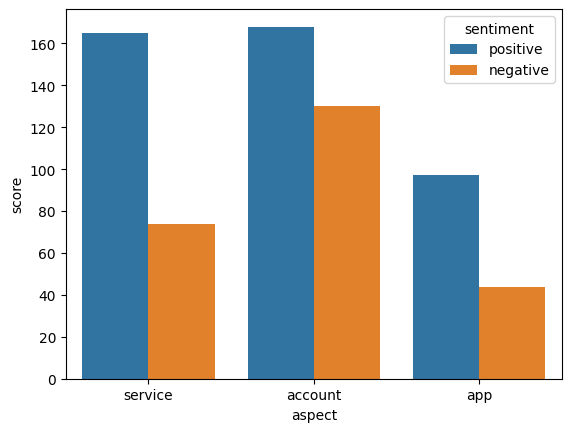

In [ ]:
df = df_axis
aspects_df_axis = aspect_sentiment(aspects)

What do you think about the customer?
{'score': 0.1373342126607895, 'start': 196, 'end': 267, 'answer': 'I have no issues with the customer support and its been good experience'}
[{'label': 'POSITIVE', 'score': 0.9896601438522339}]
What do you think about the experience?
{'score': 0.25112786889076233, 'start': 196, 'end': 267, 'answer': 'I have no issues with the customer support and its been good experience'}
[{'label': 'POSITIVE', 'score': 0.9896601438522339}]
What do you think about the convenience?
{'score': 0.21913659572601318, 'start': 147, 'end': 194, 'answer': 'convenience for deposits and update of passbook'}
[{'label': 'POSITIVE', 'score': 0.9918265342712402}]
What do you think about the service?
{'score': 0.0820779874920845, 'start': 196, 'end': 267, 'answer': 'I have no issues with the customer support and its been good experience'}
[{'label': 'POSITIVE', 'score': 0.9896601438522339}]
What do you think about the support?
{'score': 0.15284568071365356, 'start': 196, 'end': 2

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the option?
{'score': 0.28875669836997986, 'start': 69, 'end': 111, 'answer': 'There is no any option so chosen this bank'}
[{'label': 'NEGATIVE', 'score': 0.9986086487770081}]
What do you think about the service?
{'score': 0.04240794479846954, 'start': 121, 'end': 142, 'answer': 'zero  balance account'}
[{'label': 'NEGATIVE', 'score': 0.995445966720581}]
What do you think about the account?
{'score': 0.1123734563589096, 'start': 121, 'end': 142, 'answer': 'zero  balance account'}
[{'label': 'NEGATIVE', 'score': 0.995445966720581}]
What do you think about the transaction?
{'score': 0.018942231312394142, 'start': 196, 'end': 223, 'answer': 'I get alert message on time'}
[{'label': 'POSITIVE', 'score': 0.8963252902030945}]
What do you think about the charge?
{'score': 0.0777936652302742, 'start': 154, 'end': 193, 'answer': 'no hidden charge I faced from this bank'}
[{'label': 'NEGATIVE', 'score': 0.9927667379379272}]
What do you think about the app?
{'score': 0.05

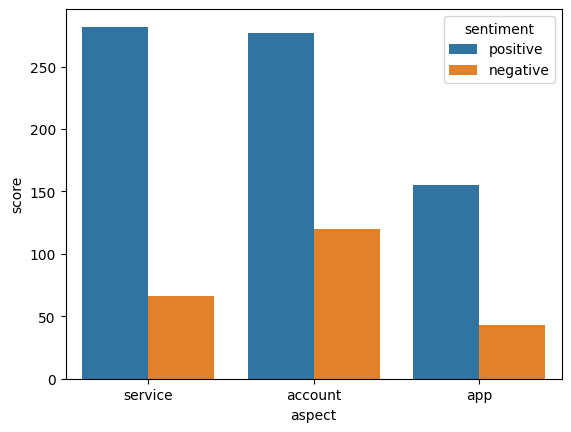

In [ ]:
df = df_hdfc
aspects_df_hdfc = aspect_sentiment(aspects)

What do you think about the service?
{'score': 0.05425576493144035, 'start': 0, 'end': 48, 'answer': 'I am not getting an alert message from IDBI bank'}
[{'label': 'NEGATIVE', 'score': 0.9996138215065002}]
What do you think about the account?
{'score': 0.03805948793888092, 'start': 195, 'end': 240, 'answer': 'holding a saving account for the past 6 years'}
[{'label': 'POSITIVE', 'score': 0.957413911819458}]
What do you think about the transaction?
{'score': 0.28564754128456116, 'start': 95, 'end': 128, 'answer': 'check the account balance details'}
[{'label': 'NEGATIVE', 'score': 0.9782650470733643}]
What do you think about the details?
{'score': 0.0836770310997963, 'start': 0, 'end': 48, 'answer': 'I am not getting an alert message from IDBI bank'}
[{'label': 'NEGATIVE', 'score': 0.9996138215065002}]
What do you think about the app?
{'score': 0.0585293173789978, 'start': 0, 'end': 48, 'answer': 'I am not getting an alert message from IDBI bank'}
[{'label': 'NEGATIVE', 'score': 0.99961

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the requirement?
{'score': 0.35790520906448364, 'start': 382, 'end': 406, 'answer': 'there was no requirement'}
[{'label': 'POSITIVE', 'score': 0.8438547253608704}]
What do you think about the service?
{'score': 0.5032402873039246, 'start': 289, 'end': 310, 'answer': 'Their service is good'}
[{'label': 'POSITIVE', 'score': 0.9998371601104736}]
What do you think about the account?
{'score': 0.2406456172466278, 'start': 289, 'end': 310, 'answer': 'Their service is good'}
[{'label': 'POSITIVE', 'score': 0.9998371601104736}]
What do you think about the app?
{'score': 0.38346561789512634, 'start': 289, 'end': 310, 'answer': 'Their service is good'}
[{'label': 'POSITIVE', 'score': 0.9998371601104736}]
What do you think about the service?
{'score': 0.20765280723571777, 'start': 215, 'end': 254, 'answer': "I'm quite satisfied with their services"}
[{'label': 'POSITIVE', 'score': 0.9997672438621521}]
What do you think about the staffs?
{'score': 0.4539586901664734, 'star

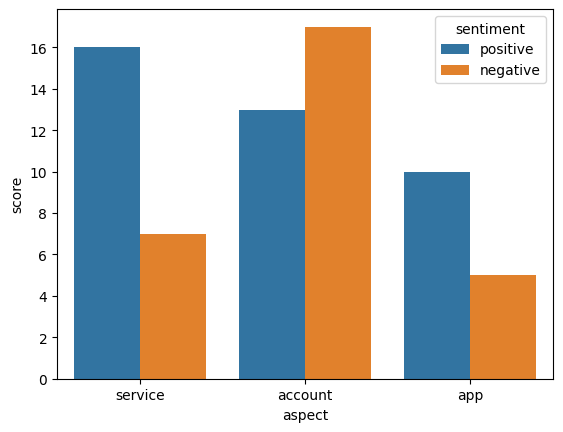

In [ ]:
df = df_idbi
aspects_df_idbi = aspect_sentiment(aspects)

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the customer?
{'score': 0.020808853209018707, 'start': 151, 'end': 172, 'answer': 'I went through online'}
[{'label': 'NEGATIVE', 'score': 0.9853529334068298}]
What do you think about the service?
{'score': 0.015779675915837288, 'start': 18, 'end': 84, 'answer': 'i am using Kotak Bank savings account and its really super service'}
[{'label': 'NEGATIVE', 'score': 0.9834950566291809}]
What do you think about the onces?
{'score': 0.07506557554006577, 'start': 308, 'end': 326, 'answer': 'lost my debit card'}
[{'label': 'NEGATIVE', 'score': 0.999692440032959}]
What do you think about the account?
{'score': 0.09599331021308899, 'start': 237, 'end': 257, 'answer': 'zero balance account'}
[{'label': 'NEGATIVE', 'score': 0.995445966720581}]
What do you think about the debit?
{'score': 0.14777250587940216, 'start': 259, 'end': 297, 'answer': "They haven't charged a debit card fees"}
[{'label': 'NEGATIVE', 'score': 0.9257495403289795}]
What do you think about the savings?


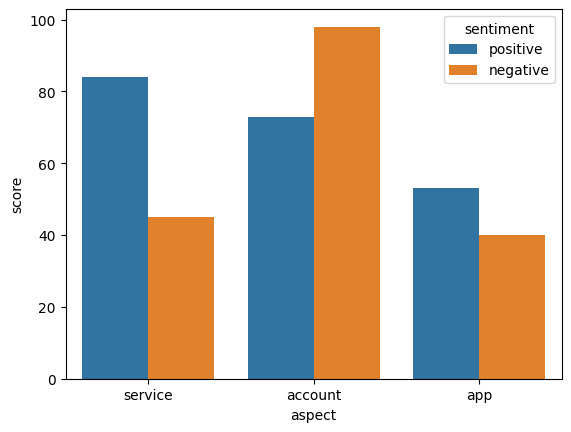

In [ ]:
df = df_kotak
aspects_df_kotak = aspect_sentiment(aspects)

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the service?
{'score': 0.08966066688299179, 'start': 264, 'end': 306, 'answer': 'I use to get offers message from their end'}
[{'label': 'NEGATIVE', 'score': 0.9845207333564758}]
What do you think about the account?
{'score': 0.02655862830579281, 'start': 63, 'end': 110, 'answer': 'I no need to maintain a minimum balance account'}
[{'label': 'POSITIVE', 'score': 0.9792354702949524}]
What do you think about the transaction?
{'score': 0.12402366101741791, 'start': 264, 'end': 306, 'answer': 'I use to get offers message from their end'}
[{'label': 'NEGATIVE', 'score': 0.9845207333564758}]
What do you think about the app?
{'score': 0.08578439056873322, 'start': 264, 'end': 306, 'answer': 'I use to get offers message from their end'}
[{'label': 'NEGATIVE', 'score': 0.9845207333564758}]
What do you think about the service?
{'score': 0.05113238841295242, 'start': 258, 'end': 285, 'answer': 'zero balance account to use'}
[{'label': 'NEGATIVE', 'score': 0.992837488651275

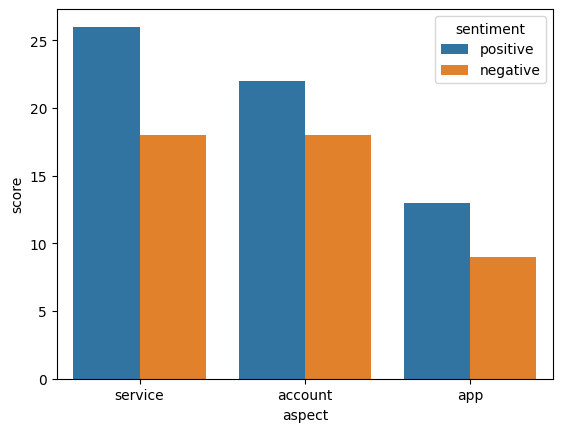

In [ ]:
df = df_indus
aspects_df_indus = aspect_sentiment(aspects)

What do you think about the option?
{'score': 0.0904872789978981, 'start': 98, 'end': 185, 'answer': 'they need to provide better option to the customer to check the account balance details'}
[{'label': 'NEGATIVE', 'score': 0.9996920824050903}]
What do you think about the customer?
{'score': 0.10937699675559998, 'start': 152, 'end': 185, 'answer': 'check the account balance details'}
[{'label': 'NEGATIVE', 'score': 0.9782650470733643}]
What do you think about the service?
{'score': 0.023655494675040245, 'start': 187, 'end': 245, 'answer': 'I use to visit branch and get good response from their end'}
[{'label': 'POSITIVE', 'score': 0.9977499842643738}]
What do you think about the account?
{'score': 0.0889165848493576, 'start': 247, 'end': 297, 'answer': 'I am holding a saving account for the past 6 years'}
[{'label': 'NEGATIVE', 'score': 0.9728484153747559}]
What do you think about the transaction?
{'score': 0.05748985335230827, 'start': 0, 'end': 50, 'answer': 'I am not getting an aler

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the service?
{'score': 0.05721097066998482, 'start': 195, 'end': 231, 'answer': 'getting alert messages from bank end'}
[{'label': 'NEGATIVE', 'score': 0.978324830532074}]
What do you think about the account?
{'score': 0.02967258170247078, 'start': 91, 'end': 149, 'answer': 'salary cums savings, no need to maintain a minimum balance'}
[{'label': 'POSITIVE', 'score': 0.6732742786407471}]
What do you think about the banking?
{'score': 0.04903724789619446, 'start': 41, 'end': 79, 'answer': 'internet banking is very user friendly'}
[{'label': 'POSITIVE', 'score': 0.9619003534317017}]
What do you think about the debit?
{'score': 0.0893736407160759, 'start': 252, 'end': 271, 'answer': 'domestic debit card'}
[{'label': 'NEGATIVE', 'score': 0.8605577945709229}]
What do you think about the app?
{'score': 0.1576051414012909, 'start': 18, 'end': 79, 'answer': 'very good app and also internet banking is very user friendly'}
[{'label': 'POSITIVE', 'score': 0.9994687438011169

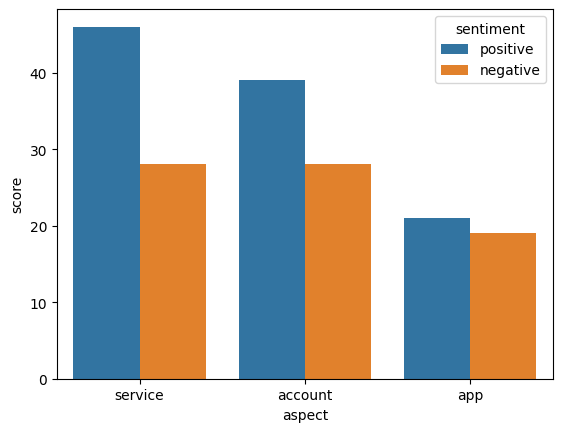

In [ ]:
df = df_canara
aspects_df_canara = aspect_sentiment(aspects)

What do you think about the facility?
{'score': 0.07893183827400208, 'start': 197, 'end': 238, 'answer': 'They are not deducting any hidden charges'}
[{'label': 'POSITIVE', 'score': 0.8916187882423401}]
What do you think about the service?
{'score': 0.06250837445259094, 'start': 197, 'end': 238, 'answer': 'They are not deducting any hidden charges'}
[{'label': 'POSITIVE', 'score': 0.8916187882423401}]
What do you think about the account?
{'score': 0.07246780395507812, 'start': 197, 'end': 238, 'answer': 'They are not deducting any hidden charges'}
[{'label': 'POSITIVE', 'score': 0.8916187882423401}]
What do you think about the banking?
{'score': 0.09519030153751373, 'start': 197, 'end': 238, 'answer': 'They are not deducting any hidden charges'}
[{'label': 'POSITIVE', 'score': 0.8916187882423401}]
What do you think about the savings?
{'score': 0.1487358957529068, 'start': 197, 'end': 238, 'answer': 'They are not deducting any hidden charges'}
[{'label': 'POSITIVE', 'score': 0.891618788

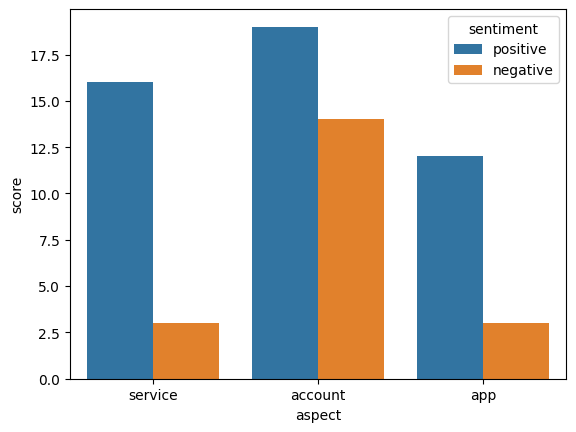

In [ ]:
df = df_citi
aspects_df_citi = aspect_sentiment(aspects)

What do you think about the customer?
{'score': 0.23229967057704926, 'start': 240, 'end': 262, 'answer': 'giving proper response'}
[{'label': 'POSITIVE', 'score': 0.9995842576026917}]
What do you think about the service?
{'score': 0.1762227863073349, 'start': 220, 'end': 262, 'answer': 'customer service is giving proper response'}
[{'label': 'POSITIVE', 'score': 0.9965182542800903}]
What do you think about the account?
{'score': 0.07000306993722916, 'start': 59, 'end': 89, 'answer': 'maintain a balance of Rs. 1500'}
[{'label': 'POSITIVE', 'score': 0.9977999329566956}]
What do you think about the savings?
{'score': 0.07599940150976181, 'start': 59, 'end': 89, 'answer': 'maintain a balance of Rs. 1500'}
[{'label': 'POSITIVE', 'score': 0.9977999329566956}]
What do you think about the app?
{'score': 0.07465741038322449, 'start': 135, 'end': 176, 'answer': 'they are deducting lots of hidden charges'}
[{'label': 'NEGATIVE', 'score': 0.9760826826095581}]
What do you think about the customer?


<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the service?
{'score': 0.15565049648284912, 'start': 69, 'end': 98, 'answer': "Their employee's are not good"}
[{'label': 'NEGATIVE', 'score': 0.999799907207489}]
What do you think about the employee?
{'score': 0.3533382713794708, 'start': 69, 'end': 98, 'answer': "Their employee's are not good"}
[{'label': 'NEGATIVE', 'score': 0.999799907207489}]
What do you think about the account?
{'score': 0.16163493692874908, 'start': 69, 'end': 98, 'answer': "Their employee's are not good"}
[{'label': 'NEGATIVE', 'score': 0.999799907207489}]
What do you think about the transaction?
{'score': 0.13081397116184235, 'start': 69, 'end': 98, 'answer': "Their employee's are not good"}
[{'label': 'NEGATIVE', 'score': 0.999799907207489}]
What do you think about the charge?
{'score': 0.15898655354976654, 'start': 259, 'end': 290, 'answer': 'They use to charge of 23 rupees'}
[{'label': 'NEGATIVE', 'score': 0.9192342162132263}]
What do you think about the app?
{'score': 0.131119400262

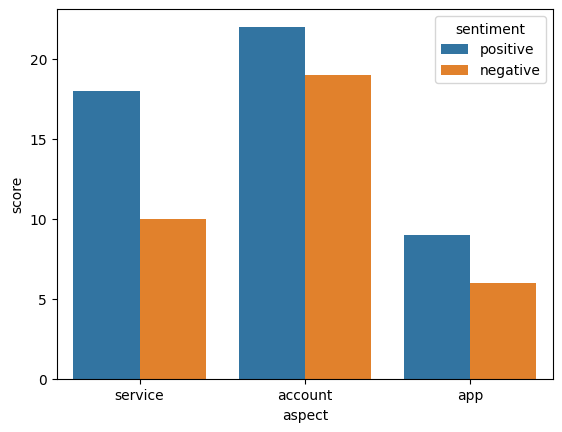

In [ ]:
df = df_pnb
aspects_df_pnb = aspect_sentiment(aspects)

What do you think about the service?
{'score': 0.04186823591589928, 'start': 123, 'end': 203, 'answer': 'I can easily transact and I can withdraw money from anywhere without any charges'}
[{'label': 'NEGATIVE', 'score': 0.9953525066375732}]
What do you think about the corporation?
{'score': 0.03205917030572891, 'start': 78, 'end': 144, 'answer': 'The most interesting part about this account I can easily transact'}
[{'label': 'POSITIVE', 'score': 0.9988528490066528}]
What do you think about the account?
{'score': 0.07355645298957825, 'start': 78, 'end': 98, 'answer': 'The most interesting'}
[{'label': 'POSITIVE', 'score': 0.9998393058776855}]
What do you think about the savings?
{'score': 0.057369064539670944, 'start': 78, 'end': 98, 'answer': 'The most interesting'}
[{'label': 'POSITIVE', 'score': 0.9998393058776855}]
What do you think about the app?
{'score': 0.04411108046770096, 'start': 123, 'end': 203, 'answer': 'I can easily transact and I can withdraw money from anywhere without 

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


Streaming output truncated to the last 5000 lines.
{'score': 0.039796676486730576, 'start': 315, 'end': 362, 'answer': 'difficult to update the home address via online'}
[{'label': 'NEGATIVE', 'score': 0.9997156262397766}]
What do you think about the app?
{'score': 0.034536492079496384, 'start': 277, 'end': 300, 'answer': 'improve the application'}
[{'label': 'POSITIVE', 'score': 0.9994423985481262}]
What do you think about the customer?
{'score': 0.44879648089408875, 'start': 92, 'end': 119, 'answer': 'I like the customer support'}
[{'label': 'POSITIVE', 'score': 0.9996933937072754}]
What do you think about the experience?
{'score': 0.4696354269981384, 'start': 78, 'end': 87, 'answer': 'very good'}
[{'label': 'POSITIVE', 'score': 0.9998520612716675}]
What do you think about the service?
{'score': 0.22796054184436798, 'start': 92, 'end': 119, 'answer': 'I like the customer support'}
[{'label': 'POSITIVE', 'score': 0.9996933937072754}]
What do you think about the insurance?
{'score': 0.

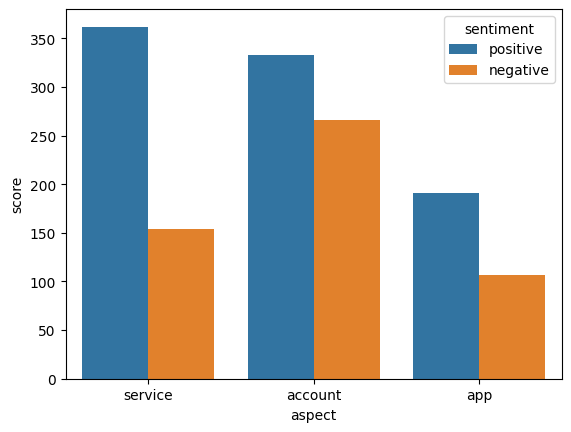

In [ ]:
df = df_unknown
aspects_df_unknown = aspect_sentiment(aspects)

What do you think about the convenience?
{'score': 0.3033103346824646, 'start': 204, 'end': 219, 'answer': 'It is very easy'}
[{'label': 'POSITIVE', 'score': 0.9990948438644409}]
What do you think about the customer?
{'score': 0.6215487122535706, 'start': 94, 'end': 119, 'answer': 'customer service was good'}
[{'label': 'POSITIVE', 'score': 0.9997828602790833}]
What do you think about the service?
{'score': 0.4966805577278137, 'start': 94, 'end': 119, 'answer': 'customer service was good'}
[{'label': 'POSITIVE', 'score': 0.9997828602790833}]
What do you think about the account?
{'score': 0.05637939274311066, 'start': 94, 'end': 119, 'answer': 'customer service was good'}
[{'label': 'POSITIVE', 'score': 0.9997828602790833}]
What do you think about the deposits?
{'score': 0.20771735906600952, 'start': 204, 'end': 254, 'answer': 'It is very easy and convenience for money deposits'}
[{'label': 'POSITIVE', 'score': 0.9972754120826721}]
What do you think about the details?
{'score': 0.099897

<ipython-input-10-6b587c2e5ade>:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


What do you think about the customer?
{'score': 0.1689283549785614, 'start': 352, 'end': 375, 'answer': 'attitude must be change'}
[{'label': 'NEGATIVE', 'score': 0.9813557267189026}]
What do you think about the service?
{'score': 0.02483213134109974, 'start': 179, 'end': 213, 'answer': 'Mostly i am not taking cash at ATM'}
[{'label': 'NEGATIVE', 'score': 0.996868908405304}]
What do you think about the employees?
{'score': 0.3984455466270447, 'start': 352, 'end': 375, 'answer': 'attitude must be change'}
[{'label': 'NEGATIVE', 'score': 0.9813557267189026}]
What do you think about the access?
{'score': 0.0414217971265316, 'start': 179, 'end': 213, 'answer': 'Mostly i am not taking cash at ATM'}
[{'label': 'NEGATIVE', 'score': 0.996868908405304}]
What do you think about the account?
{'score': 0.04829920455813408, 'start': 179, 'end': 213, 'answer': 'Mostly i am not taking cash at ATM'}
[{'label': 'NEGATIVE', 'score': 0.996868908405304}]
What do you think about the banking?
{'score': 0.02

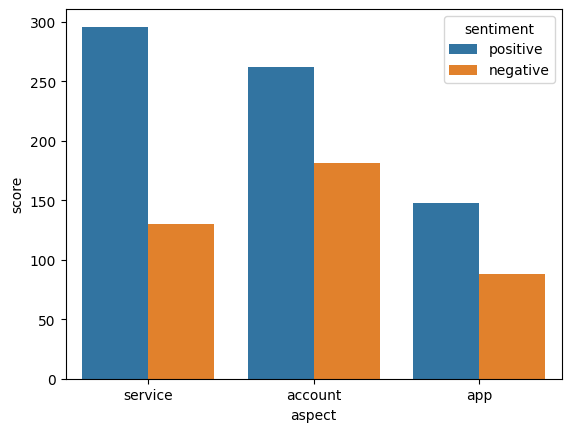

In [ ]:
df = df_sbi
aspects_df_sbi = aspect_sentiment(aspects)

In [ ]:
aspects_df_sbi.to_csv('aspects_sentiment_sbi.csv', index = False)
aspects_df_axis.to_csv('aspects_sentiment_axis.csv', index = False)
aspects_df_hdfc.to_csv('aspects_sentiment_hdfc.csv', index = False)
aspects_df_idbi.to_csv('aspects_sentiment_idbi.csv', index = False)
aspects_df_kotak.to_csv('aspects_sentiment_kotak.csv', index = False)
aspects_df_indus.to_csv('aspects_sentiment_indus.csv', index = False)
aspects_df_canara.to_csv('aspects_sentiment_canara.csv', index = False)
aspects_df_citi.to_csv('aspects_sentiment_citi.csv', index = False)
aspects_df_pnb.to_csv('aspects_sentiment_pnb.csv', index = False)
aspects_df_unknown.to_csv('aspects_sentiment_unknown.csv', index = False)